In [22]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
#import torch.utils.tensorboard as tb
from Preprocessing.preprocessing_reading_text_files import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd

In [23]:
#static parameters
train_batch_size = 60
val_batch_size = 60
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 41
clip = 3

In [24]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\traj' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

41
[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
{127: 'G9', 126: 'F#9/G-9', 125: 'F9', 124: 'E9', 123: 'D#9/E-9', 122: 'D9', 121: 'C#9/D-9', 120: 'C9', 119: 'B8', 118: 'A#8/B-8', 117: 'A8', 116: 'G#8/A-8', 115: 'G8', 114: 'F#8/G-8', 113: 'F8', 112: 'E8', 111: 'D#8/E-8', 110: 'D8', 109: 'C#8/D-8', 108: 'C8', 107: 'B7', 106: 'A#7/B-7', 105: 'A7', 104: 'G#7/A-7', 103: 'G7', 102: 'F#7/G-7', 101: 'F7', 100: 'E7', 99: 'D#7/E-7', 98: 'D7', 97: 'C#7/D-7', 96: 'C7', 95: 'B6', 94: 'A#6/B-6', 93: 'A6', 92: 'G#6/A-6', 91: 'G6', 90: 'F#6/G-6', 89: 'F6', 88: 'E6', 87: 'D#6/E-6', 86: 'D6', 85: 'C#6/D-6', 84: 'C6', 83: 'B5', 82: 'A#5/B-5', 81: 'A5', 80: 'G#5/A-5', 79: 'G5', 78: 'F#5/G-5', 77: 'F5', 76: 'E5', 75: 'D#5/E-5', 74: 'D5', 73: 'C#5/D-5', 72: 'C5', 71: 'B4', 70: 'A#4/B-4', 69: 'A4', 68: 'G#4/A-4', 67: 'G4', 66: 'F#4/G-4', 65: 'F4', 64: 'E4', 63: 'D#4/E-4', 62: 'D4', 61: 'C#4

In [25]:
print(network_output.max())
print(network_output.min())


tensor(40, device='cuda:0')
tensor(0, device='cuda:0')


In [26]:
network_input=(network_input.cpu().numpy().tolist())
for i in range(len(network_input)):
    for j in range(len(network_input[i])):
        network_input[i][j][0]=((network_input[i][j][0])*(max_midi_number-min_midi_number)+min_midi_number)/max_midi_number
network_input=torch.Tensor(network_input).cuda()

In [27]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0.5556, device='cuda:0')
90
50
{0: 50, 1: 51, 2: 52, 3: 53, 4: 54, 5: 55, 6: 56, 7: 57, 8: 58, 9: 59, 10: 60, 11: 61, 12: 62, 13: 63, 14: 64, 15: 65, 16: 66, 17: 67, 18: 68, 19: 69, 20: 70, 21: 71, 22: 72, 23: 73, 24: 74, 25: 75, 26: 76, 27: 77, 28: 78, 29: 79, 30: 80, 31: 81, 32: 82, 33: 83, 34: 84, 35: 85, 36: 86, 37: 87, 38: 88, 39: 89, 40: 90}


In [28]:
'''
data is highly unbalanced
# '''
# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

'\ndata is highly unbalanced\n# '

In [37]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -58]
network_output = network_output[: -58]

print(network_input.shape)
print(network_output.shape)

torch.Size([3000, 50, 1])
torch.Size([3000])


In [38]:
# # Bakchodi Normalization
# network_input=network_input.cpu().numpy().tolist()
# for i in range(len(network_input)):
#     for j in range(len(network_input[i])):
#         network_input[i][j][0]=((network_input[i][j][0])*(max_midi_number-min_midi_number)+min_midi_number)/max_midi_number
# network_input=torch.Tensor(network_input).cuda()

In [39]:
#network_input[:10]

In [40]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = hidden_size, hidden_size = output_size,batch_first = True)
        
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(output_size, output_size)
        
        
    def forward(self, x, batch_size):
        
        output, _ = self.lstm1(x)        
        #print(output.shape)
        
        #output = self.dropout(output)
        
        output, _ = self.lstm2(output)
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, 41)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight) 

In [41]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [42]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 41, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=41, out_features=41, bias=True)
)

In [43]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [44]:
epochs = 700
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        
        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output = model.forward(inputs, train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        output = model.forward(inputs, val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256-38-our_normalization_bakchodi_text_files.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.7069556 	Val Loss:3.6594327 	Train Acc: 3.5% 	Val Acc: 6.3333336%
Validation Loss decreased from    inf to 3.659433, saving the model weights
Epoch: 1	Train Loss: 3.6978627 	Val Loss:3.6284817 	Train Acc: 2.291667% 	Val Acc: 4.3333335%
Validation Loss decreased from 3.659433 to 3.628482, saving the model weights
Epoch: 2	Train Loss: 3.6786136 	Val Loss:3.6172207 	Train Acc: 2.75% 	Val Acc: 1.5000001%
Validation Loss decreased from 3.628482 to 3.617221, saving the model weights
Epoch: 3	Train Loss: 3.6682724 	Val Loss:3.6143053 	Train Acc: 2.5% 	Val Acc: 2.3333334%
Validation Loss decreased from 3.617221 to 3.614305, saving the model weights
Epoch: 4	Train Loss: 3.6661001 	Val Loss:3.6111070 	Train Acc: 2.208333% 	Val Acc: 1.5000001%
Validation Loss decreased from 3.614305 to 3.611107, saving the model weights
Epoch: 5	Train Loss: 3.6622595 	Val Loss:3.6104720 	Train Acc: 2.125% 	Val Acc: 1.5000001%
Validation Loss decreased from 3.611107 to 3.610472, saving the m

Validation Loss decreased from 3.589174 to 3.588695, saving the model weights
Epoch: 54	Train Loss: 3.6380342 	Val Loss:3.5887082 	Train Acc: 2.166667% 	Val Acc: 0.0000000%
Epoch: 55	Train Loss: 3.6380529 	Val Loss:3.5888958 	Train Acc: 2.041667% 	Val Acc: 0.0000000%
Epoch: 56	Train Loss: 3.6363619 	Val Loss:3.5890409 	Train Acc: 2.583333% 	Val Acc: 0.5000000%
Epoch: 57	Train Loss: 3.6359763 	Val Loss:3.5893891 	Train Acc: 2.625% 	Val Acc: 0.0000000%
Epoch: 58	Train Loss: 3.6384891 	Val Loss:3.5893646 	Train Acc: 2.208333% 	Val Acc: 0.5000000%
Epoch: 59	Train Loss: 3.6371856 	Val Loss:3.5888720 	Train Acc: 2.708333% 	Val Acc: 0.5000000%
Epoch: 60	Train Loss: 3.6381938 	Val Loss:3.5886773 	Train Acc: 2.5% 	Val Acc: 0.5000000%
Validation Loss decreased from 3.588695 to 3.588677, saving the model weights
Epoch: 61	Train Loss: 3.6372207 	Val Loss:3.5880928 	Train Acc: 2.208333% 	Val Acc: 0.8333334%
Validation Loss decreased from 3.588677 to 3.588093, saving the model weights
Epoch: 62	Trai

Validation Loss decreased from 3.583819 to 3.583775, saving the model weights
Epoch: 120	Train Loss: 3.6343553 	Val Loss:3.5838497 	Train Acc: 1.958333% 	Val Acc: 0.8333334%
Epoch: 121	Train Loss: 3.6340623 	Val Loss:3.5837903 	Train Acc: 2.5% 	Val Acc: 0.8333334%
Epoch: 122	Train Loss: 3.6333428 	Val Loss:3.5839995 	Train Acc: 2.25% 	Val Acc: 0.8333334%
Epoch: 123	Train Loss: 3.6327974 	Val Loss:3.5839385 	Train Acc: 2.625% 	Val Acc: 0.5000000%
Epoch: 124	Train Loss: 3.6329280 	Val Loss:3.5839886 	Train Acc: 2.166667% 	Val Acc: 0.5000000%
Epoch: 125	Train Loss: 3.6324182 	Val Loss:3.5837543 	Train Acc: 2.291667% 	Val Acc: 0.5000000%
Validation Loss decreased from 3.583775 to 3.583754, saving the model weights
Epoch: 126	Train Loss: 3.6322647 	Val Loss:3.5834317 	Train Acc: 2.208333% 	Val Acc: 0.5000000%
Validation Loss decreased from 3.583754 to 3.583432, saving the model weights
Epoch: 127	Train Loss: 3.6337856 	Val Loss:3.5835385 	Train Acc: 1.791667% 	Val Acc: 0.5000000%
Epoch: 128

Epoch: 190	Train Loss: 3.6318728 	Val Loss:3.5818631 	Train Acc: 2.25% 	Val Acc: 0.5000000%
Epoch: 191	Train Loss: 3.6328898 	Val Loss:3.5818761 	Train Acc: 1.791667% 	Val Acc: 0.8333334%
Epoch: 192	Train Loss: 3.6319928 	Val Loss:3.5819311 	Train Acc: 2.708333% 	Val Acc: 0.8333334%
Epoch: 193	Train Loss: 3.6311407 	Val Loss:3.5818247 	Train Acc: 1.75% 	Val Acc: 0.8333334%
Epoch: 194	Train Loss: 3.6326557 	Val Loss:3.5817761 	Train Acc: 2.208333% 	Val Acc: 0.8333334%
Epoch: 195	Train Loss: 3.6318248 	Val Loss:3.5817305 	Train Acc: 2.708333% 	Val Acc: 2.6666668%
Validation Loss decreased from 3.581745 to 3.581731, saving the model weights
Epoch: 196	Train Loss: 3.6323376 	Val Loss:3.5817662 	Train Acc: 2.0% 	Val Acc: 2.6666668%
Epoch: 197	Train Loss: 3.6322557 	Val Loss:3.5819615 	Train Acc: 1.916667% 	Val Acc: 2.6666668%
Epoch: 198	Train Loss: 3.6324920 	Val Loss:3.5820528 	Train Acc: 2.041667% 	Val Acc: 2.6666668%
Epoch: 199	Train Loss: 3.6310541 	Val Loss:3.5820333 	Train Acc: 2.3333

Validation Loss decreased from 3.580728 to 3.580635, saving the model weights
Epoch: 261	Train Loss: 3.6310046 	Val Loss:3.5806179 	Train Acc: 2.125% 	Val Acc: 0.5000000%
Validation Loss decreased from 3.580635 to 3.580618, saving the model weights
Epoch: 262	Train Loss: 3.6307534 	Val Loss:3.5808099 	Train Acc: 2.333333% 	Val Acc: 0.5000000%
Epoch: 263	Train Loss: 3.6311805 	Val Loss:3.5809652 	Train Acc: 2.208333% 	Val Acc: 0.5000000%
Epoch: 264	Train Loss: 3.6309352 	Val Loss:3.5808415 	Train Acc: 2.5% 	Val Acc: 0.5000000%
Epoch: 265	Train Loss: 3.6315739 	Val Loss:3.5807003 	Train Acc: 2.0% 	Val Acc: 1.3333334%
Epoch: 266	Train Loss: 3.6311818 	Val Loss:3.5808140 	Train Acc: 2.666667% 	Val Acc: 1.3333334%
Epoch: 267	Train Loss: 3.6312041 	Val Loss:3.5807532 	Train Acc: 2.375% 	Val Acc: 2.6666668%
Epoch: 268	Train Loss: 3.6316473 	Val Loss:3.5807943 	Train Acc: 1.916667% 	Val Acc: 2.6666668%
Epoch: 269	Train Loss: 3.6317037 	Val Loss:3.5808993 	Train Acc: 1.958333% 	Val Acc: 2.66666

Epoch: 334	Train Loss: 3.6308693 	Val Loss:3.5801732 	Train Acc: 2.166667% 	Val Acc: 2.6666668%
Epoch: 335	Train Loss: 3.6303726 	Val Loss:3.5801649 	Train Acc: 2.166667% 	Val Acc: 1.3333334%
Epoch: 336	Train Loss: 3.6306365 	Val Loss:3.5800734 	Train Acc: 1.875% 	Val Acc: 5.1666669%
Validation Loss decreased from 3.580080 to 3.580073, saving the model weights
Epoch: 337	Train Loss: 3.6302610 	Val Loss:3.5801145 	Train Acc: 2.416667% 	Val Acc: 5.1666669%
Epoch: 338	Train Loss: 3.6303809 	Val Loss:3.5799491 	Train Acc: 2.333333% 	Val Acc: 5.1666669%
Validation Loss decreased from 3.580073 to 3.579949, saving the model weights
Epoch: 339	Train Loss: 3.6302283 	Val Loss:3.5799295 	Train Acc: 1.958333% 	Val Acc: 1.3333334%
Validation Loss decreased from 3.579949 to 3.579930, saving the model weights
Epoch: 340	Train Loss: 3.6304677 	Val Loss:3.5799155 	Train Acc: 2.291667% 	Val Acc: 1.3333334%
Validation Loss decreased from 3.579930 to 3.579915, saving the model weights
Epoch: 341	Train Lo

Validation Loss decreased from 3.579574 to 3.579543, saving the model weights
Epoch: 408	Train Loss: 3.6298565 	Val Loss:3.5796134 	Train Acc: 1.875% 	Val Acc: 2.3333335%
Epoch: 409	Train Loss: 3.6302967 	Val Loss:3.5796317 	Train Acc: 1.625% 	Val Acc: 2.3333335%
Epoch: 410	Train Loss: 3.6310464 	Val Loss:3.5795971 	Train Acc: 1.625% 	Val Acc: 2.1666668%
Epoch: 411	Train Loss: 3.6308770 	Val Loss:3.5796083 	Train Acc: 1.666667% 	Val Acc: 2.8333334%
Epoch: 412	Train Loss: 3.6305317 	Val Loss:3.5796350 	Train Acc: 1.625% 	Val Acc: 2.1666668%
Epoch: 413	Train Loss: 3.6305663 	Val Loss:3.5796603 	Train Acc: 2.041667% 	Val Acc: 2.1666668%
Epoch: 414	Train Loss: 3.6302233 	Val Loss:3.5796624 	Train Acc: 1.958333% 	Val Acc: 2.1666668%
Epoch: 415	Train Loss: 3.6304238 	Val Loss:3.5796878 	Train Acc: 1.708333% 	Val Acc: 2.1666668%
Epoch: 416	Train Loss: 3.6302563 	Val Loss:3.5796606 	Train Acc: 2.166667% 	Val Acc: 2.1666668%
Epoch: 417	Train Loss: 3.6304022 	Val Loss:3.5796508 	Train Acc: 2.125

Epoch: 490	Train Loss: 3.6297173 	Val Loss:3.5795497 	Train Acc: 2.0% 	Val Acc: 0.5000000%
Epoch: 491	Train Loss: 3.6300544 	Val Loss:3.5796095 	Train Acc: 1.333333% 	Val Acc: 0.5000000%
Epoch: 492	Train Loss: 3.6302157 	Val Loss:3.5795926 	Train Acc: 2.041667% 	Val Acc: 0.5000000%
Epoch: 493	Train Loss: 3.6298420 	Val Loss:3.5796008 	Train Acc: 1.125% 	Val Acc: 0.5000000%
Epoch: 494	Train Loss: 3.6299347 	Val Loss:3.5795783 	Train Acc: 2.166667% 	Val Acc: 0.5000000%
Epoch: 495	Train Loss: 3.6304671 	Val Loss:3.5796066 	Train Acc: 1.291667% 	Val Acc: 2.3333335%
Epoch: 496	Train Loss: 3.6299846 	Val Loss:3.5795741 	Train Acc: 1.958333% 	Val Acc: 2.1666668%
Epoch: 497	Train Loss: 3.6298080 	Val Loss:3.5795478 	Train Acc: 1.541667% 	Val Acc: 0.5000000%
Epoch: 498	Train Loss: 3.6299034 	Val Loss:3.5795937 	Train Acc: 1.791667% 	Val Acc: 2.1666668%
Epoch: 499	Train Loss: 3.6298010 	Val Loss:3.5796261 	Train Acc: 1.375% 	Val Acc: 2.1666668%
Epoch: 500	Train Loss: 3.6297373 	Val Loss:3.579595

Epoch: 574	Train Loss: 3.6294864 	Val Loss:3.5795708 	Train Acc: 1.958333% 	Val Acc: 2.3333335%
Epoch: 575	Train Loss: 3.6300241 	Val Loss:3.5795642 	Train Acc: 1.708333% 	Val Acc: 2.3333335%
Epoch: 576	Train Loss: 3.6295375 	Val Loss:3.5795787 	Train Acc: 2.041667% 	Val Acc: 2.1666668%
Epoch: 577	Train Loss: 3.6295000 	Val Loss:3.5796273 	Train Acc: 1.791667% 	Val Acc: 2.1666668%
Epoch: 578	Train Loss: 3.6294456 	Val Loss:3.5796036 	Train Acc: 1.541667% 	Val Acc: 1.3333334%
Epoch: 579	Train Loss: 3.6297910 	Val Loss:3.5795806 	Train Acc: 2.0% 	Val Acc: 1.3333334%
Epoch: 580	Train Loss: 3.6297835 	Val Loss:3.5796671 	Train Acc: 1.625% 	Val Acc: 1.3333334%
Epoch: 581	Train Loss: 3.6300852 	Val Loss:3.5796657 	Train Acc: 1.708333% 	Val Acc: 1.3333334%
Epoch: 582	Train Loss: 3.6295461 	Val Loss:3.5796501 	Train Acc: 1.708333% 	Val Acc: 1.3333334%
Epoch: 583	Train Loss: 3.6296892 	Val Loss:3.5796557 	Train Acc: 1.958333% 	Val Acc: 1.3333334%
Epoch: 584	Train Loss: 3.6295868 	Val Loss:3.579

Epoch: 660	Train Loss: 3.6297115 	Val Loss:3.5795929 	Train Acc: 1.708333% 	Val Acc: 1.3333334%
Epoch: 661	Train Loss: 3.6292682 	Val Loss:3.5795510 	Train Acc: 2.041667% 	Val Acc: 1.3333334%
Epoch: 662	Train Loss: 3.6292096 	Val Loss:3.5795405 	Train Acc: 2.125% 	Val Acc: 1.3333334%
Epoch: 663	Train Loss: 3.6295506 	Val Loss:3.5795146 	Train Acc: 1.708333% 	Val Acc: 1.3333334%
Epoch: 664	Train Loss: 3.6294630 	Val Loss:3.5795213 	Train Acc: 1.916667% 	Val Acc: 1.3333334%
Epoch: 665	Train Loss: 3.6295828 	Val Loss:3.5795816 	Train Acc: 2.083333% 	Val Acc: 1.3333334%
Epoch: 666	Train Loss: 3.6294885 	Val Loss:3.5795257 	Train Acc: 1.791667% 	Val Acc: 1.3333334%
Epoch: 667	Train Loss: 3.6292802 	Val Loss:3.5795166 	Train Acc: 1.5% 	Val Acc: 1.3333334%
Epoch: 668	Train Loss: 3.6296325 	Val Loss:3.5794614 	Train Acc: 1.583333% 	Val Acc: 1.3333334%
Epoch: 669	Train Loss: 3.6297004 	Val Loss:3.5794934 	Train Acc: 2.458333% 	Val Acc: 1.3333334%
Epoch: 670	Train Loss: 3.6296039 	Val Loss:3.579

## MUSIC GENERATION

In [26]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256-38-our_normalization_bakchodi_text_files.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [27]:
#load population database
#testing_data = np.ones(200)*1
# testing_data = list(range(50,90))
# testing_data.extend(testing_data[::-1])
# testing_data_rev = testing_data[::-1]
# testing_data_rev.extend(testing_data)
# testing_data_rev.extend(testing_data_rev)
# testing_data = testing_data_rev


# testing_data = np.asarray(testing_data)
# testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

testing_data_unnorm = testing_data

In [28]:
#abc

In [29]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    list1[i]=(list1[i]-50)/(89-50)
#     list1[i]=(list1[i])/(89)

list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [30]:
#testing_data

In [31]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, min_note,test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
        
        test_output = test_model.forward(test_slice, test_batch_size)
    
        test_output = F.softmax(test_output, dim = 1)
        top_p, top_class = test_output.topk(1,dim =1)
        
        test_seq[0][sequence_length - 1 + i][0] = (int2note[top_class.item()] - min_note)/(max_note - min_note)
#         test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [32]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number, min_midi_number)

In [33]:
#predicted_notes_lst

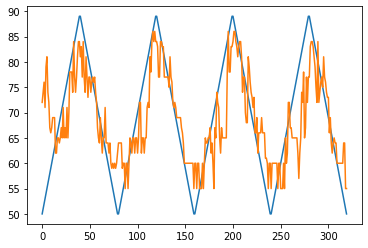

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.plot(list(np.ones(200)*89))

#plt.plot(list(np.ones(200)*50))
#plt.plot(list(np.ones(20)*50))
plt.plot(testing_data_unnorm*89)
plt.plot(predicted_notes_lst)

In [25]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({72: 15,
         74: 22,
         76: 17,
         78: 10,
         79: 10,
         81: 19,
         83: 9,
         67: 7,
         77: 82,
         88: 10,
         86: 19,
         82: 22,
         89: 5,
         84: 45,
         71: 14,
         73: 7,
         69: 5,
         75: 1,
         80: 1})

In [46]:
from Postprocessing.postprocessing import PostProcessing
PostProcessing().generate_midi_file('hello.midi', predicted_notes_lst)

In [45]:
#int_to_note